# Challenge OWKIN 2020

The goal of the challenge is to predict a patient's life expectancy using structured data extracted by experts and scans of tumors. As expected, the code was done in less than 10 hours and would need further work, though it produces a decent score of 0.71 on the public test set. 

One of the first difficulty that we can notice is the high potential for overfitting. The scans are shaped 92\*92\*92 and even without them the clinic and radio datasets have quite a lot of features, whereas on the other hand only 300 samples were given as training samples. Our goal is firstly to format the data, then project it on smaller feature spaces to prevent overfitting and finally tune the model. 


The following work was done on the data:
- *scans*: Though a better work could have been done (detailed at the end), as a first approach I used as features the sum of scan\*mask and the mean of scan\*mask. It is a very simple feature space projection which still seems to have its relevance regarding the correlation with the output variable. 

- *Structured data*: As expressed in the description, the data was selected adequately but might bring some overfitting. In order to avoid this I went for a standard scaling followed by a PCA to project the meaningful informations on a reduced dimension. Several tries were made using a percentage of explainability (ex 80%) or fixed n_components. It seems that if more than one or two columns were extracted, the model would tend to overfit on the training set. The best model submitted for the competition had a training test accuracy of 0.74, a final score of 0.71 and used History dummification and 1 n_component for PCA as well as the sum and mean of scans. 

The model:
I went for an XGBRegressor model due to its current high state of the art results as well as the ability to be easily explained through the shapley values of the contribution of the features. Though it is important to note that the model has a high tendency to overfit, even more than RandomForests for instance. It is expected that it might have trouble predicting outliers and to overfit on the training set. Compared to the benchmark model, it doesn't exploit the fact that we are looking at survivality which is a downside. The model was opposed on the draft to other models such as SVR which performed poorly and conforted me on this choice. 

Model training:
In order to avoid overfitting I went for a 5-fold cross-validation. It is a tricky choice since we are given 300 train data and 100 test data. A small number of k-fold will bias the selection due to a poor number of training samples and a high k-fold will increase the standard deviation of the results. In the end, 5 folds were chosen as a balance between both. 
Furthermore, the hyperparameters were tuned using Hyperopt's bayesian optimisation on the score of the 5-fold cross-validation. The final parameters were checked to be far from overfitting. In practice, we want less than 100 n_estimators and and a max_depth less than 10 (which can still be considered a bit high). 



Submission and errors:
The first submitted models were trained on a split of the original dataset which eventually lowered the score. One model also performed poorly since it was overfitting too much on the training set. As pointed earlier, the best model had a training score of 0.74 meaning that it managed to balance the overfitting and do better on the test set. The model compiled in this notebook got a score of 0.70 on the public test set. 


Improvements:
As expressed, those are my suggestions for futher improvements if given more time. Firstly, I am clearly lacking some feature extraction from the scans. A first step would be to generate data using data augmentation techniques (rotation, translation,...) in order to get more than 1000 scans of data. Then I would train an autoencoder/variational autoencoder to project the information on latent space in a dimension <10 ideally. On the structured data, I think the History column might need some work. For now it is dummified but it projects the column in a high dimension space, which is not what we are looking for. I already tried to avoid using it but the information proved to be highly important for the prediction. One other small point worth mentioning would be the age imputation. For now I used the median robust estimator, which proved highly useful if less than 10% of the column is missing, but ultimately it would be nice to predict the age using the other columns, for instance using a KNN algorithm.
Finally regarding the model, even though XGBRegressor is a good naive approach, a model such as the exponential one used in the benchmark might be more suited to the realistic expectation of the curve. 


Thank you for your attention and I hope that you won't have too much trouble reading the code. I left some of the research ideas commented even though they proved to push the model to overfit. Other ideas were tried on a draft notebook, but I selected only the most relevant ones. 

In [436]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from xgboost import XGBRegressor

from os.path import isfile, join
import pickle

from metrics_t9gbvr2 import cindex

In [394]:
labels = pd.read_csv('output_VSVxRFU.csv')
labels.set_index('PatientID', inplace = True)

#Structured data column names and label column name
cols = ['age', 'shape', 'shape.1', 'shape.2', 'shape.3', 'shape.4', 'shape.5', 'shape.6', 'shape.7', 'firstorder', 'firstorder.1', 'firstorder.2', 'firstorder.3', 'firstorder.4', 'firstorder.5', 'firstorder.6', 'firstorder.7', 'firstorder.8', 'firstorder.9', 'firstorder.10', 'firstorder.11', 'firstorder.12', 'firstorder.13', 'textural', 'textural.1', 'textural.2', 'textural.3', 'textural.4', 'textural.5', 'textural.6', 'textural.7', 'textural.8', 'textural.9', 'textural.10', 'textural.11', 'textural.12', 'textural.13', 'textural.14', 'textural.15', 'textural.16', 'textural.17', 'textural.18', 'textural.19', 'textural.20', 'textural.21', 'textural.22', 'textural.23', 'textural.24', 'textural.25', 'textural.26', 'textural.27', 'textural.28', 'textural.29', 'textural.30']
labs = 'SurvivalTime'

In [395]:
#List of structured data column names by category
shape = ['shape' + (i>0)*('.'+str(i)) for i in range(8)]
firstorder = ['firstorder' + (i>0)*('.'+str(i)) for i in range(8)]
textural = ['textural' + (i>0)*('.'+str(i)) for i in range(8)]

In [454]:
#train data
train_img = np.load('train/images/patient_002.npz')

train_clinic = pd.read_csv('train/features/clinical_data.csv')
train_clinic.set_index('PatientID', inplace = True)

train_radio = pd.read_csv('train/features/radiomics.csv')
train_radio.drop([0,1], axis = 'index', inplace = True)
train_radio.rename(columns = {'Unnamed: 0':'PatientID'}, inplace = True)
train_radio.PatientID = train_radio.PatientID.astype(int)
train_radio.set_index('PatientID', inplace = True)

In [456]:
train_clinic.isna().sum()

Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

In [5]:
#test data
test_img = np.load('test/images/patient_000.npz')

test_clinic = pd.read_csv('test/features/clinical_data.csv')
test_clinic.set_index('PatientID', inplace = True)

test_radio = pd.read_csv('test/features/radiomics.csv')
test_radio.drop([0,1], axis = 'index', inplace = True)
test_radio.rename(columns = {'Unnamed: 0':'PatientID'}, inplace = True)
test_radio.PatientID = test_radio.PatientID.astype(int)
test_radio.set_index('PatientID', inplace = True)

In [6]:
# function computing the sum over the scans
def get_img_score(train_path,x):
    if x<10:
        x = '00' + str(x)
    elif x <100:
        x = '0' + str(x)
    else:
        x = str(x)
    try:
        archive = np.load(join(train_path, 'patient_'+x+'.npz'))
        scan = archive['scan']/1468
        mask = archive['mask']
        return np.sum(scan*mask)/1000
    except:
        print(x)
        return 0

In [396]:
# function computing the mean over the scans
def get_img_mean(train_path,x):
    if x<10:
        x = '00' + str(x)
    elif x <100:
        x = '0' + str(x)
    else:
        x = str(x)
    try:
        archive = np.load(join(train_path, 'patient_'+x+'.npz'))
        scan = archive['scan']
        mask = archive['mask']
        return np.mean(np.abs(scan*mask))
    except:
        print(x)
        return 0

In [66]:
# standard scaler initialized to prepare the data for the PCA
ss = StandardScaler()

In [256]:
# PCA for each categories
pca_shape = PCA(n_components = 0.7)
pca_firstorder = PCA(n_components = 0.7)
pca_textural = PCA(n_components = 0.7)

In [460]:
def data_preproc(radio, clinic, labels_file, img_path, isTrain = True):
    data = clinic.join(radio).copy()
    if isTrain == True:
        data = data.join(labels_file)

    data.age.fillna(data.age.median(), inplace = True)
    data.Histology.replace({'NSCLC NOS (not otherwise specified)':'nos'}, inplace = True)
    
#     data = pd.concat( [data, pd.get_dummies(data.Histology)], axis = 1)
#     data = pd.concat( [data, pd.get_dummies(data['Tstage'], prefix = 'Tstage')], axis = 1)
#     data = pd.concat( [data, pd.get_dummies(data['Mstage'], prefix = 'Mstage')], axis = 1)
#     data = pd.concat( [data, pd.get_dummies(data['Nstage'], prefix = 'Nstage')], axis = 1)
#     data.drop(['Histology','Tstage', 'Mstage', 'Nstage'], axis = 1, inplace = True)
    data.drop(['Histology'], axis = 1, inplace = True)
    data[cols] = data[cols].astype(float)
    
    if isTrain:
        data[cols] = ss.fit_transform(data[cols])
    else:
        data[cols] = ss.transform(data[cols])
    
    ### PCA ###
    if isTrain:
        pca_tmp = pca_shape.fit_transform(data[shape])
        data[['shape_pca_' + str(i) for i in range(pca_tmp.shape[1])]] = pd.DataFrame(pca_tmp, index = data.index)
        pca_tmp = pca_firstorder.fit_transform(data[firstorder])
        data[['firstorder_pca_' + str(i) for i in range(pca_tmp.shape[1])]] = pd.DataFrame(pca_tmp, index = data.index)
        pca_tmp = pca_textural.fit_transform(data[textural])
        data[['textural_pca_' + str(i) for i in range(pca_tmp.shape[1])]] = pd.DataFrame(pca_tmp, index = data.index)
    else:
        pca_tmp = pca_shape.transform(data[shape])
        data[['shape_pca_' + str(i) for i in range(pca_tmp.shape[1])]] = pd.DataFrame(pca_tmp, index = data.index)
        pca_tmp = pca_firstorder.transform(data[firstorder])
        data[['firstorder_pca_' + str(i) for i in range(pca_tmp.shape[1])]] = pd.DataFrame(pca_tmp, index = data.index)
        pca_tmp = pca_textural.transform(data[textural])
        data[['textural_pca_' + str(i) for i in range(pca_tmp.shape[1])]] = pd.DataFrame(pca_tmp, index = data.index)
    data.drop(cols, axis = 1, inplace = True)
    
    return data

In [461]:
data_train = data_preproc(train_radio, train_clinic, labels,'./train/images/')
data_test = data_preproc(test_radio, test_clinic, labels,'./test/images/', isTrain = False)

In [462]:
data_train

,Mstage,Nstage,SourceDataset,Tstage,SurvivalTime,Event,shape_pca_0,shape_pca_1,firstorder_pca_0,firstorder_pca_1,textural_pca_0,textural_pca_1
PatientID,,,,,,,,,,,,
202,0,0,l2,2,1378,0,-0.830600,0.034007,-2.307590,0.287602,2.053017,0.835997
371,0,2,l1,4,379,1,0.892186,-0.226221,-0.192364,0.006052,-0.541691,0.939867
246,0,3,l1,2,573,1,-0.119138,0.689737,1.529755,-1.295150,-1.725234,-0.805583
240,0,2,l1,3,959,0,-0.730886,-0.378335,0.327809,-0.787129,-0.797156,-0.193129
284,0,3,l1,4,2119,0,0.133947,-0.841689,0.562773,0.041384,-0.579851,2.001987
...,...,...,...,...,...,...,...,...,...,...,...,...
261,0,0,l1,1,1540,0,-2.933744,1.187694,-1.111169,-0.788674,-0.279851,0.192695
298,0,0,l1,1,946,0,4.864467,-2.084270,3.655249,1.021581,-2.654627,-0.322042
129,0,1,l1,3,559,0,0.126126,0.191267,4.070920,-0.705283,-2.590921,-1.229763


In [463]:
data_train['img_score'] = [get_img_score('./train/images', x) for x in data_train.index]
data_train['img_mean'] = [get_img_mean('./train/images', x) for x in data_train.index]
data_test['img_score'] = [get_img_score('./test/images', x) for x in data_test.index]
data_test['img_mean'] = [get_img_mean('./test/images', x) for x in data_test.index]

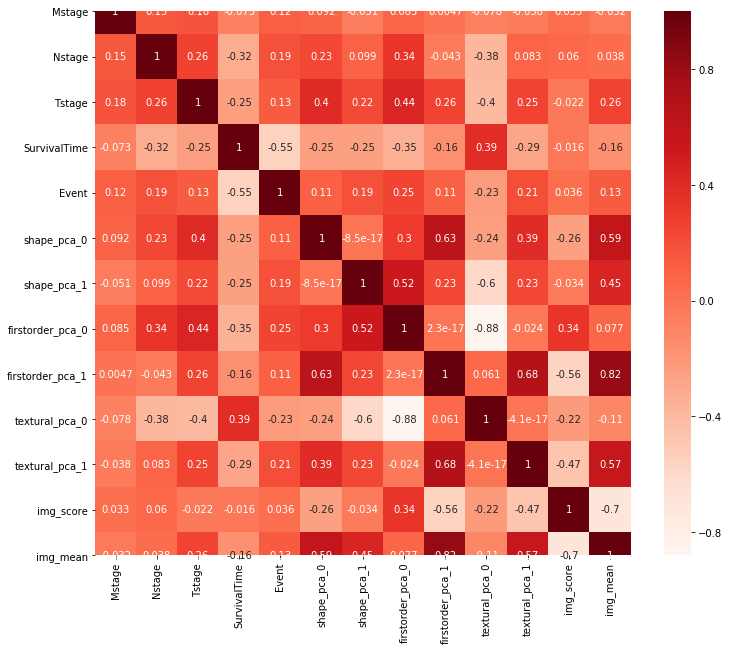

In [470]:
#Using Pearson Correlation 
plt.figure(figsize = (12,10))
cor = data_train.corr() 
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) 
plt.show()

In [385]:
np.sum(data_train.img_mean.isna())

0

In [386]:
def get_cols(data):
    data_cols = list(data.columns)
    data_cols.remove('SourceDataset')
    try:
        data_cols.remove('SurvivalTime')
        data_cols.remove('Event')
    except:
        pass
    return data_cols

In [387]:
train_cols = get_cols(data_train)
test_cols = get_cols(data_test)

In [388]:
def format_score(p, d):
    res = pd.DataFrame({'SurvivalTime': p, 'Event': ['nan']*d.shape[0]},index = d.index)
    return res

In [392]:
#Hyperparameter tuning using hyperopt
space = {
            'n_estimators': hp.choice('n_estimators', range(50,70, 10)),
            'max_depth': hp.choice('max_depth', range(1,10)),
            'max_features': hp.choice('max_features', range(1,5)),
            'min_child_weight':hp.quniform('min_child_weight', 0.5,1.0,0.1),
            'gamma': hp.uniform('gamma', 0, 10.0)
        }

def f(params):
    kf = KFold(n_splits=5, shuffle = True)
    kf.get_n_splits(data_train)

    res = []
    for train_index, test_index in kf.split(data_train):
        model = XGBRegressor(n_jobs = -1, objective = 'reg:squarederror')
        model.fit(data_train[train_cols].iloc[train_index], data_train[labs].iloc[train_index])

        preds = labels.iloc[test_index].copy()
        preds.Event = [np.nan]*preds.shape[0]
        preds.SurvivalTime = model.predict(data_train[train_cols].iloc[test_index])
        def r(x):
            return max(2,x)
        preds.SurvivalTime = preds.SurvivalTime.apply(r)
        y_true = labels.iloc[test_index]

        res += [cindex(y_true, preds)]
    acc = np.mean(res)
    return {'loss': -acc, 'status': STATUS_OK}

res = fmin(f, space, algo=tpe.suggest, max_evals=500)
print(res)

100%|████████████████████████████████████████████████| 500/500 [03:19<00:00,  2.51it/s, best loss: -0.6587248763128168]
{'gamma': 4.729879362959323, 'max_depth': 0, 'max_features': 2, 'min_child_weight': 0.5, 'n_estimators': 1}


In [420]:
params = {
    'gamma': res['gamma'],
    'max_depth': range(1,10)[res['max_depth']],
    'max_features': range(1,5)[res['max_features']],
    'min_child_weight':res['min_child_weight'],
    'n_estimators': range(50,70, 10)[res['n_estimators']],
    'n_jobs':-1,
    'objective': 'reg:squarederror'
    }

# defining model with best params
model = XGBRegressor(**params)

In [428]:
X_train, X_test, y_train, y_test = train_test_split(data_train[train_cols], data_train[labs])

model.fit(X_train, y_train)

preds = model.predict(X_train)
print('Model score on training set: %.2f' %cindex(labels.loc[y_train.index], format_score(preds, X_train)))

preds = model.predict(X_test)
print('Model score on test set: %.2f' %cindex(labels.loc[y_test.index], format_score(preds, X_test)))

Model score on training set: 0.70
Model score on test set: 0.70


In [430]:
# Fitting model on training data to check the overfiting
model = XGBRegressor(**params)
model.fit(data_train[train_cols], data_train[labs])
preds = model.predict(data_train[train_cols])
cindex(labels, format_score(preds, data_train))

0.7052328524421965

Explaining the prediction using Shapley's values from the SHAP framework. First you can see the absolute value of the contribution, then on the second plot the direction of the contribution. 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


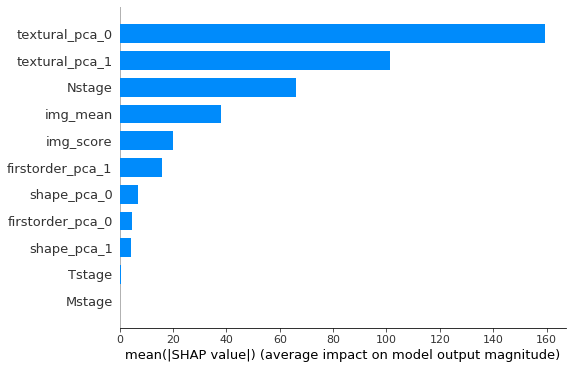

In [433]:
#Fiting Shap explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_train[train_cols])

shap.summary_plot(shap_values, data_train[train_cols], plot_type="bar")

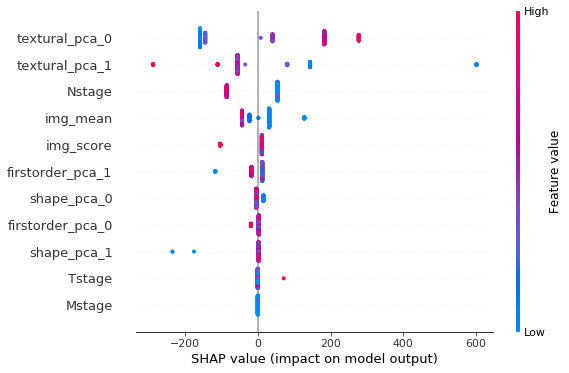

In [434]:
shap.summary_plot(shap_values, data_train[train_cols])

In [133]:
#Parameters for the submission
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 6.1916178918891545,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 1,
 'min_child_weight': 0.5,
 'missing': None,
 'n_estimators': 60,
 'objective': 'reg:squarederror',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1,
 'max_features': 1}

In [437]:
#Saving model
with open('model_final', 'wb') as f:
    pickle.dump(model, f)

# Test section

In [441]:
#We make sure that we have the same amount of columns in both datasets. Due to the dummification some can be missing in the test set
data_test.drop(set(test_cols)-set(train_cols), axis = 1, inplace = True)
for el in (set(train_cols)-set(test_cols)):
    data_test[el] = [0]*data_test.shape[0]
test_cols = get_cols(data_test)

In [444]:
#predicting the test set
preds = model.predict(data_test[train_cols])

In [445]:
res = format_score(preds, data_test)

In [451]:
#Checking for abnormal values
print(res.SurvivalTime.min())
print(res.SurvivalTime.max())

378.7712097167969
1777.5804443359375


In [452]:
res

,SurvivalTime,Event
PatientID,,
13,746.991516,nan
155,1180.244507,nan
404,715.957275,nan
407,758.761414,nan
9,1653.737305,nan
...,...,...
66,515.166870,nan
132,544.475342,nan
169,1635.146484,nan


In [453]:
res.to_csv('submission_final.csv')